# Import Model

In [75]:
from cameo import models
from cameo import load_model
from cameo import fba
from escher import Builder
import pandas as pd
import numpy as np

# Simulate Model

In [2]:
model = load_model('iML1515')
model

Using license file /home/matinnu/gurobi.lic
Academic license - for non-commercial use only


Name,iML1515
Memory address,0x07f4cb32fc7d0
Number of metabolites,1877
Number of reactions,2712
Number of groups,0
Objective expression,0.0 + 1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
Compartments,"cytosol, extracellular space, periplasm"


In [78]:
model.solver = 'gurobi'

In [4]:
%time fba_result = fba(model)

CPU times: user 359 ms, sys: 31.2 ms, total: 391 ms
Wall time: 437 ms


In [5]:
#fba_result.display_on_map("iJO1366.Central metabolism") #seems cameo not updated with escher yet

In [6]:
fba_result[model.reactions.BIOMASS_Ec_iML1515_core_75p37M]

0.8769972144269728

In [7]:
builder = Builder(
    map_name='e_coli_core.Core metabolism',
    reaction_data=fba_result.fluxes,
)
builder

Builder(reaction_data={'CYTDK2': 0.0, 'XPPT': 0.0, 'HXPRT': 0.0, 'NDPK5': -0.022947509112696166, 'SHK3Dr': 0.3…

# Xylitol strain knockout model

In [8]:
# copy model to create mutant
mutant_xylitol = model.copy()

Read LP format model from file /tmp/tmph8_tbsuo.lp
Reading time = 0.02 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Read LP format model from file /tmp/tmpvhhsi1v1.lp
Reading time = 0.04 seconds
: 1877 rows, 5424 columns, 21150 nonzeros


In [9]:
# create list of genes to KO
ko_list = pd.read_csv('data/df_xylitol_knockouts.csv', index_col=0).dropna(subset = ['id_bigg'])
ko_list.iML1515_idx = ko_list.iML1515_idx.astype(int)
ko_list

,gene,uniprot,strain,Entry,Entry name,Gene names (primary ),Gene names (synonym ),Protein names,Gene ontology (molecular function),Catalytic activity,Reaction,id_bigg,iML1515_idx
0,focA,https://www.uniprot.org/uniprot/P0AC23,xylytol_mutant,P0AC23,FOCA_ECOLI,focA,ycaE,Probable formate transporter 1 (Formate channe...,formate transmembrane transporter activity [GO...,NaN,NaN,b0904,1023
1,pflB,https://www.uniprot.org/uniprot/P09373,xylytol_mutant,P09373,PFLB_ECOLI,pflB,pfl,Formate acetyltransferase 1 (EC 2.3.1.54) (Pyr...,formate C-acetyltransferase activity [GO:0008861],CATALYTIC ACTIVITY: Reaction=acetyl-CoA + form...,acetyl-CoA + formate = CoA + pyruvate,b0903,162
2,ldhA,https://www.uniprot.org/uniprot/P52643,xylytol_mutant,P52643,LDHD_ECOLI,ldhA,hslI htpH,D-lactate dehydrogenase (D-LDH) (EC 1.1.1.28) ...,D-lactate dehydrogenase activity [GO:0008720];...,CATALYTIC ACTIVITY: Reaction=(R)-lactate + NAD...,(R)-lactate + NAD(+) = H(+) + NADH + pyruvate,b1380,1135
3,adhE,https://www.uniprot.org/uniprot/P0A9Q7,xylytol_mutant,P0A9Q7,ADHE_ECOLI,adhE,ana,Aldehyde-alcohol dehydrogenase [Includes: Alco...,acetaldehyde dehydrogenase (acetylating) activ...,CATALYTIC ACTIVITY: Reaction=a primary alcohol...,a primary alcohol + NAD(+) = an aldehyde + H(+...,b1241,100
5,frdA,https://www.uniprot.org/uniprot/P00363,xylytol_mutant,P00363,FRDA_ECOLI,frdA,NaN,Fumarate reductase flavoprotein subunit (EC 1....,electron transfer activity [GO:0009055]; FAD b...,CATALYTIC ACTIVITY: Reaction=a quinone + succi...,a quinone + succinate = a quinol + fumarate,b4154,171
6,cyoB,https://www.uniprot.org/uniprot/P0ABI8,xylytol_mutant,P0ABI8,CYOB_ECOLI,cyoB,NaN,Cytochrome bo(3) ubiquinol oxidase subunit 1 (...,copper ion binding [GO:0005507]; cytochrome bo...,CATALYTIC ACTIVITY: Reaction=2 a ubiquinol + n...,2 a ubiquinol + n H(+)(in) + O2 = 2 a ubiquino...,b0431,1216
7,appB,https://www.uniprot.org/uniprot/P26458,xylytol_mutant,P26458,APPB_ECOLI,appB,cbdB cyxB,Cytochrome bd-II ubiquinol oxidase subunit 2 (...,electron transfer activity [GO:0009055]; metal...,CATALYTIC ACTIVITY: Reaction=2 a ubiquinol + n...,2 a ubiquinol + n H(+)(in) + O2 = 2 a ubiquino...,b0979,799


In [10]:
for i in ko_list.iML1515_idx:
    mutant_xylitol.genes[i].knock_out()

In [11]:
for i in ko_list.iML1515_idx:
    print(mutant_xylitol.genes[i])
    for x in model.genes[i].reactions:
        print('model : '+str(x))
        print(x.bounds)
    for x in mutant_xylitol.genes[i].reactions:
        print('mutant : '+str(x.id))
        print(x.bounds)
    print("___________________________")

b0904
model : FORtppi: for_c --> for_p
(0.0, 1000.0)
model : FORt2pp: for_p + h_p --> for_c + h_c
(0.0, 1000.0)
mutant : FORtppi
(0.0, 1000.0)
mutant : FORt2pp
(0.0, 1000.0)
___________________________
b0903
model : PFL: coa_c + pyr_c --> accoa_c + for_c
(0.0, 1000.0)
model : OBTFL: 2obut_c + coa_c --> for_c + ppcoa_c
(0.0, 1000.0)
mutant : PFL
(0.0, 1000.0)
mutant : OBTFL
(0.0, 1000.0)
___________________________
b1380
model : LDH_D: lac__D_c + nad_c <=> h_c + nadh_c + pyr_c
(-1000.0, 1000.0)
mutant : LDH_D
(0, 0)
___________________________
b1241
model : ACALD: acald_c + coa_c + nad_c <=> accoa_c + h_c + nadh_c
(-1000.0, 1000.0)
model : ALCD2x: etoh_c + nad_c <=> acald_c + h_c + nadh_c
(-1000.0, 1000.0)
model : ALCD19: glyald_c + h_c + nadh_c <=> glyc_c + nad_c
(-1000.0, 1000.0)
mutant : ALCD2x
(-1000.0, 1000.0)
mutant : ACALD
(-1000.0, 1000.0)
mutant : ALCD19
(-1000.0, 1000.0)
___________________________
b4154
model : FRD2: fum_c + mql8_c --> mqn8_c + succ_c
(0.0, 1000.0)
model : FR

In [12]:
%time fba_knockout_xylitol = fba(mutant_xylitol)
fba_knockout_xylitol[mutant_xylitol.reactions.BIOMASS_Ec_iML1515_core_75p37M]

CPU times: user 406 ms, sys: 93.8 ms, total: 500 ms
Wall time: 532 ms


0.7776142830847718

In [13]:
builder = Builder(
    map_name='e_coli_core.Core metabolism',
    reaction_data=fba_knockout_xylitol.fluxes,
)
builder

Builder(reaction_data={'CYTDK2': 0.0, 'XPPT': 0.0, 'HXPRT': 0.0, 'NDPK5': 0.0, 'SHK3Dr': 0.29636357795498514, …

# Isobutyric strain knockout model

In [76]:
# copy model to create mutant
mutant_isobutyric = load_model('result/iML1515_isobutyric_strain.xml')#model.copy()

In [15]:
# create list of genes to KO
ko_list = pd.read_csv('data/df_isobutyric_knockouts.csv', index_col=0).dropna(subset = ['id_bigg'])
ko_list.iML1515_idx = ko_list.iML1515_idx.astype(int)
ko_list

,gene,uniprot,strain,Entry,Entry name,Gene names (primary ),Gene names (synonym ),Protein names,Gene ontology (molecular function),Catalytic activity,Reaction,id_bigg,iML1515_idx
0,pflB,https://www.uniprot.org/uniprot/P09373,isobutyric_mutant,P09373,PFLB_ECOLI,pflB,pfl,Formate acetyltransferase 1 (EC 2.3.1.54) (Pyr...,formate C-acetyltransferase activity [GO:0008861],CATALYTIC ACTIVITY: Reaction=acetyl-CoA + form...,acetyl-CoA + formate = CoA + pyruvate,b0903,162
2,poxB,https://www.uniprot.org/uniprot/P07003,isobutyric_mutant,P07003,POXB_ECOLI,poxB,NaN,Pyruvate dehydrogenase [ubiquinone] (EC 1.2.5....,flavin adenine dinucleotide binding [GO:005066...,CATALYTIC ACTIVITY: Reaction=a ubiquinone + H2...,a ubiquinone + H2O + pyruvate = a ubiquinol + ...,b0871,175
3,tdcE,https://www.uniprot.org/uniprot/P42632,isobutyric_mutant,P42632,TDCE_ECOLI,tdcE,yhaS,PFL-like enzyme TdcE (Keto-acid formate acetyl...,2-ketobutyrate formate-lyase activity [GO:0043...,CATALYTIC ACTIVITY: Reaction=2-oxobutanoate + ...,2-oxobutanoate + CoA = formate + propanoyl-CoA,b3114,147
4,pflDC,https://www.uniprot.org/uniprot/P32675,isobutyric_mutant,P32675,PFLC_ECOLI,pflC,yijM,Pyruvate formate-lyase 2-activating enzyme (EC...,[formate-C-acetyltransferase]-activating enzym...,CATALYTIC ACTIVITY: Reaction=glycyl-[formate C...,glycyl-[formate C-acetyltransferase] + reduced...,b3952,154
5,deoC,https://www.uniprot.org/uniprot/P0A6L0,isobutyric_mutant,P0A6L0,DEOC_ECOLI,deoC,dra thyR,Deoxyribose-phosphate aldolase (DERA) (EC 4.1....,deoxyribose-phosphate aldolase activity [GO:00...,CATALYTIC ACTIVITY: Reaction=2-deoxy-D-ribose ...,2-deoxy-D-ribose 5-phosphate = acetaldehyde + ...,b4381,678
6,ydbK,https://www.uniprot.org/uniprot/P52647,isobutyric_mutant,P52647,NIFJ_ECOLI,ydbK,NaN,Probable pyruvate-flavodoxin oxidoreductase (E...,"4 iron, 4 sulfur cluster binding [GO:0051539];...",CATALYTIC ACTIVITY: Reaction=CoA + 2 H(+) + ox...,CoA + 2 H(+) + oxidized [flavodoxin] + pyruvat...,b1378,1428
7,yqhD,https://www.uniprot.org/uniprot/Q46856,isobutyric_mutant,Q46856,YQHD_ECOLI,yqhD,NaN,Alcohol dehydrogenase YqhD (EC 1.1.1.-),alcohol dehydrogenase (NADP+) activity [GO:000...,CATALYTIC ACTIVITY: Reaction=a primary alcohol...,a primary alcohol + NADP(+) = an aldehyde + H(...,b3011,77
8,araB,https://www.uniprot.org/uniprot/P08204,isobutyric_mutant,P08204,ARAB_ECOLI,araB,NaN,Ribulokinase (EC 2.7.1.16),ATP binding [GO:0005524]; phosphotransferase a...,CATALYTIC ACTIVITY: Reaction=ATP + D-ribulose ...,ATP + D-ribulose = ADP + D-ribulose 5-phosphat...,b0063,131
9,araA,https://www.uniprot.org/uniprot/P08202,isobutyric_mutant,P08202,ARAA_ECOLI,araA,NaN,L-arabinose isomerase (EC 5.3.1.4),L-arabinose isomerase activity [GO:0008733]; m...,CATALYTIC ACTIVITY: Reaction=L-arabinose = L-r...,L-arabinose = L-ribulose,b0062,525
10,xylAB,https://www.uniprot.org/uniprot/P09099,isobutyric_mutant,P09099,XYLB_ECOLI,xylB,NaN,Xylulose kinase (XK) (Xylulokinase) (EC 2.7.1....,ATP binding [GO:0005524]; xylulokinase activit...,CATALYTIC ACTIVITY: Reaction=ATP + D-xylulose ...,ATP + D-xylulose = ADP + D-xylulose 5-phosphat...,b3564,129


In [16]:
for i in ko_list.iML1515_idx:
    mutant_isobutyric.genes[i].knock_out()

In [17]:
for i in ko_list.iML1515_idx:
    print(mutant_isobutyric.genes[i])
    for x in model.genes[i].reactions:
        print('model : '+str(x))
        print(x.bounds)
    for x in mutant_isobutyric.genes[i].reactions:
        print('mutant : '+str(x.id))
        print(x.bounds)
    print("___________________________")

b0903
model : PFL: coa_c + pyr_c --> accoa_c + for_c
(0.0, 1000.0)
model : OBTFL: 2obut_c + coa_c --> for_c + ppcoa_c
(0.0, 1000.0)
mutant : OBTFL
(0, 0)
mutant : PFL
(0, 0)
___________________________
b0871
model : POX: h2o_c + pyr_c + q8_c --> ac_c + co2_c + q8h2_c
(0.0, 1000.0)
mutant : POX
(0, 0)
___________________________
b3114
model : PFL: coa_c + pyr_c --> accoa_c + for_c
(0.0, 1000.0)
model : OBTFL: 2obut_c + coa_c --> for_c + ppcoa_c
(0.0, 1000.0)
mutant : OBTFL
(0, 0)
mutant : PFL
(0, 0)
___________________________
b3952
model : PFL: coa_c + pyr_c --> accoa_c + for_c
(0.0, 1000.0)
mutant : PFL
(0, 0)
___________________________
b4381
model : DRPA: 2dr5p_c --> acald_c + g3p_c
(0.0, 1000.0)
mutant : DRPA
(0, 0)
___________________________
b1378
model : POR5: coa_c + 2.0 flxso_c + pyr_c <=> accoa_c + co2_c + 2.0 flxr_c + h_c
(-1000.0, 1000.0)
mutant : POR5
(0, 0)
___________________________
b3011
model : ALDD3y: h2o_c + nadp_c + ppal_c --> 2.0 h_c + nadph_c + ppa_c
(0.0, 1000.0

In [80]:
mutant_isobutyric.solver = 'gurobi'
%time fba_knockout_isobutyric = fba(mutant_isobutyric)
fba_knockout_isobutyric[mutant_isobutyric.reactions.BIOMASS_Ec_iML1515_core_75p37M]

CPU times: user 219 ms, sys: 0 ns, total: 219 ms
Wall time: 209 ms


0.8769075284668423

In [81]:
builder = Builder(
    map_name='e_coli_core.Core metabolism',
    reaction_data=fba_knockout_isobutyric.fluxes,
)
builder

Builder(reaction_data={'CYTDK2': 0.0, 'XPPT': 0.0, 'HXPRT': 0.0, 'NDPK5': -0.022945162389863393, 'SHK3Dr': 0.3…

# Compare

In [82]:
builder = Builder(
    map_name='e_coli_core.Core metabolism',
    reaction_data=fba_result.fluxes,
)
builder

Builder(reaction_data={'CYTDK2': 0.0, 'XPPT': 0.0, 'HXPRT': 0.0, 'NDPK5': -0.022947509112696166, 'SHK3Dr': 0.3…

In [84]:
builder = Builder(
    map_name='e_coli_core.Core metabolism',
    reaction_data=fba_knockout_isobutyric.fluxes,
)
builder

Builder(reaction_data={'CYTDK2': 0.0, 'XPPT': 0.0, 'HXPRT': 0.0, 'NDPK5': -0.022945162389863393, 'SHK3Dr': 0.3…

In [21]:
builder = Builder(
    map_name='e_coli_core.Core metabolism',
    reaction_data=fba_knockout_xylitol.fluxes,
)
builder

Builder(reaction_data={'CYTDK2': 0.0, 'XPPT': 0.0, 'HXPRT': 0.0, 'NDPK5': 0.0, 'SHK3Dr': 0.29636357795498514, …

In [23]:
normal_flux = fba_result.fluxes.to_frame()
normal_flux = normal_flux.rename(columns={'fluxes':'normal'})

In [24]:
xylitol_flux = fba_knockout_xylitol.fluxes.to_frame()
xylitol_flux = xylitol_flux.rename(columns={'fluxes':'xylitol'})

In [25]:
isobutyric_flux = fba_knockout_isobutyric.fluxes.to_frame()
isobutyric_flux = isobutyric_flux.rename(columns={'fluxes':'isobutyric'})

In [26]:
result = normal_flux.join(xylitol_flux)
result = result.join(isobutyric_flux)
result

,normal,xylitol,isobutyric
CYTDK2,0.000000,0.000000,0.000000
XPPT,0.000000,0.000000,0.000000
HXPRT,0.000000,0.000000,0.000000
NDPK5,-0.022948,0.000000,0.000000
SHK3Dr,0.334240,0.296364,0.334206
...,...,...,...
MPTS,0.000000,0.000000,0.000000
MOCOS,0.000000,0.000000,0.000000
BMOGDS2,0.000000,0.000000,0.000000
FESD2s,0.000000,0.000000,0.000000


In [27]:
flux_no_zeroes = (result != 0).any(axis=1)
flux_no_zeroes = result.loc[flux_no_zeroes]
flux_no_zeroes['d_xylitol'] = flux_no_zeroes['xylitol'] - flux_no_zeroes['normal']
flux_no_zeroes['d_isobutyric'] = flux_no_zeroes['isobutyric'] - flux_no_zeroes['normal']
flux_no_zeroes

/home/matinnu/anaconda3/envs/lab_rotation_3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/matinnu/anaconda3/envs/lab_rotation_3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,normal,xylitol,isobutyric,d_xylitol,d_isobutyric
NDPK5,-0.022948,0.000000,0.000000,0.022948,2.294751e-02
SHK3Dr,0.334240,0.296364,0.334206,-0.037877,-3.418102e-05
NDPK8,0.000000,-0.020347,0.000000,-0.020347,0.000000e+00
DHORTS,-0.290106,-0.257231,-0.290077,0.032875,2.966767e-05
OMPDC,0.290106,0.257231,0.290077,-0.032875,-2.966767e-05
...,...,...,...,...,...
TYRL,0.000196,0.000173,0.000196,-0.000022,-1.999997e-08
THZPSN3,0.000196,0.000173,0.000196,-0.000022,-1.999997e-08
PAI2T,0.000393,0.000348,0.000393,-0.000045,-4.017931e-08
4HTHRK,0.000587,0.000520,0.000587,-0.000066,-5.999991e-08


In [28]:
delta_flux = flux_no_zeroes.drop(columns=['normal','xylitol','isobutyric'])

<AxesSubplot:>

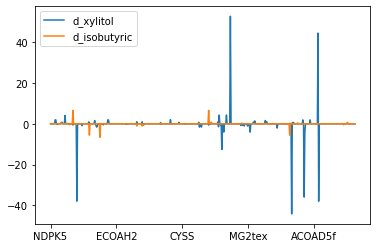

In [29]:
delta_flux.plot()

In [30]:
delta_flux.d_xylitol.nlargest(25)

CYTBDpp     52.839704
NADH16pp    44.570045
O2tpp        4.291298
O2tex        4.291298
EX_co2_e     4.079213
AKGDH        2.043186
MDH          1.939550
FUM          1.939550
CS           1.936330
ICDHyr       1.936330
ACONTb       1.936330
ACONTa       1.936330
PGI          1.626776
PDH          1.621671
EX_h2o_e     1.454784
EX_nh4_e     1.073327
DHAPT        1.018247
F6PA         1.018247
ENO          0.952028
Htex         0.913170
GLUDy        0.849856
PPM          0.818017
GAPD         0.781305
PRPPS        0.725258
ADK3         0.715788
Name: d_xylitol, dtype: float64

In [31]:
delta_flux.d_isobutyric.nlargest(25)

PFK_3       6.629099
FBA3        6.629099
ADK3        0.715788
PYK3        0.692769
ALATA_L     0.371164
PYK2        0.349989
DHORDfum    0.288651
PDH         0.077758
FLDR2       0.072423
PGL         0.055753
GND         0.055753
G6PDH2r     0.055753
RPE         0.037238
ATPS4rpp    0.026737
FRD3        0.025005
NADH18pp    0.025005
NDPK5       0.022948
RNDR2       0.022945
PYK6        0.022945
TRDR        0.022923
TKT2        0.018636
TKT1        0.018602
PGK         0.018369
PGM         0.018214
SUCOAS      0.017183
Name: d_isobutyric, dtype: float64

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

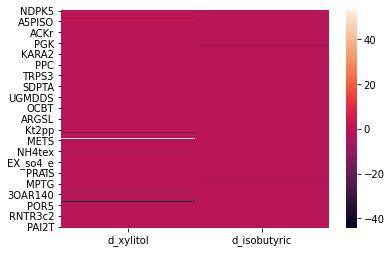

In [33]:
sns.heatmap(delta_flux)

In [34]:
model.medium

{'EX_pi_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_glc__D_e': 10.0,
 'EX_zn2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_sel_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_slnt_e': 1000.0}

In [37]:
model.metabolites.get_by_id('isobuta')

KeyError: 'isobuta'

In [38]:
mutant_isobutyric.metabolites.get_by_id('isobuta')

KeyError: 'isobuta'

In [69]:
from cobra import Model, Reaction, Metabolite
reaction = Reaction('kivD_heterologous')
reaction.name = 'alpha-ketoisovalerate-decarboxylase'
reaction.subsystem = 'Alternate Carbon Metabolism'
reaction.lower_bound = 0.  # This is the default
reaction.upper_bound = 1000.  # This is the default

In [67]:
h_c = model.metabolites.h_c
co2_c = model.metabolites.co2_c
mob_c = 

In [70]:
isobuta_c = Metabolite(
    'isobuta_c',
    formula='C4H8O2',
    name='2-methylpropanoic-acid',
    compartment='c')

isobuta_e = Metabolite(
    'isobuta_e',
    formula='C4H8O2',
    name='2-methylpropanoic-acid',
    compartment='e')

mppal = Metabolite(
    '2mppal_c',
    formula='C4H8O',
    name='2-methylpropanal',
    compartment='c')

#h_c = Metabolite('h_c', formula='H', name='H', compartment='c')
#co2_c = Metabolite('co2_c', formula='CO2', name='CO2', compartment='c')


In [71]:
reaction.add_metabolites({
    3mob_c: -1.0,
    h_c: -1.0,
    co2_c: 1.0,
    2mppal_c: 1.0
})

reaction.reaction  

SyntaxError: invalid syntax (<ipython-input-71-817fcdb81671>, line 2)

In [55]:
reaction = Reaction('feaB_heterologous')
reaction.name = 'isobutyraldehyde dehydrogenase'
reaction.subsystem = 'Alternate Carbon Metabolism'
reaction.lower_bound = 0.  # This is the default
reaction.upper_bound = 1000.  # This is the default

In [61]:
reaction.add_metabolites({
    h_c: 2.0,
    h2o_c: -1.0,
    nad_c: -1.0,
    nadh_c: 1.0,
    mppal_c: -1.0,
    isobuta_c: 1.0
})

reaction.reaction  

NameError: name 'h_c' is not defined

In [74]:
import cobra
cobra.manipulation.remove_genes

<module 'cobra.manipulation' from '/home/matinnu/anaconda3/envs/lab_rotation_3/lib/python3.7/site-packages/cobra/manipulation/__init__.py'>

In [85]:
builder = Builder(
    map_name='e_coli_core.Core metabolism')